In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_images(folder_path, image_size=(28, 28), val_split=0.2, random_state=42):
    print(f"Loading images from {folder_path}...")
    data, labels = [], []
    label_encoder = LabelEncoder()

    # Get the list of folder names
    folder_names = sorted(os.listdir(folder_path))
    label_encoder.fit(folder_names)  # Fit the encoder with folder names as labels

    for label_name in folder_names:
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue

        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            try:
                # Load and preprocess the image
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(image_size)  # Resize to the target size
                img_array = np.array(img).flatten() / 255.0  # Flatten and normalize
                data.append(img_array)
                labels.append(label_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    data = np.array(data)
    labels = label_encoder.transform(labels)  # Encode labels as integers

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        data, labels, test_size=val_split, random_state=random_state, stratify=labels
    )

    print(f"Loaded {len(data)} images from {len(folder_names)} classes.")
    print(f"Train set size: {len(X_train)}, Validation set size: {len(X_val)}")

    return X_train, X_val, y_train, y_val, label_encoder

In [ ]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.quantiles = 20

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            leaf_value = self._calculate_leaf_value(y)
            return self.Node(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            leaf_value = self._calculate_leaf_value(y)
            return self.Node(value=leaf_value)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left_child = self._build_tree(X[left_idxs], y[left_idxs], depth + 1)
        right_child = self._build_tree(X[right_idxs], y[right_idxs], depth + 1)

        return self.Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples <= 1:
            return None, None

        best_mse = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(n_features):
            thresholds, mse_values = self._find_thresholds_and_mse(X[:, feature], y)

            # Only proceed if there are valid MSE values and thresholds
            if mse_values:
                min_mse_index = np.argmin(mse_values)
                if mse_values[min_mse_index] < best_mse:
                    best_mse = mse_values[min_mse_index]
                    best_feature = feature
                    best_threshold = thresholds[min_mse_index]

        return best_feature, best_threshold

    def _find_thresholds_and_mse(self, feature_values, y):
        sorted_indices = np.argsort(feature_values)
        feature_values, y = feature_values[sorted_indices], y[sorted_indices]
        unique_thresholds = np.unique(feature_values)
        quantiles = np.linspace(0, 1, num=self.quantiles + 2)[1:-1]  # Exclude 0 and 1
        sampled_thresholds = np.quantile(unique_thresholds, quantiles)  # Get quantile values

        mse_values = []
        thresholds = []

        for threshold in sampled_thresholds:
            left_idxs = feature_values <= threshold
            right_idxs = feature_values > threshold
            if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
                continue

            mse = self._calculate_mse(y[left_idxs], y[right_idxs])
            mse_values.append(mse)
            thresholds.append(threshold)

        return thresholds, mse_values

    def _calculate_mse(self, left_y, right_y):
        left_mse = np.var(left_y) * len(left_y) if len(left_y) > 0 else 0
        right_mse = np.var(right_y) * len(right_y) if len(right_y) > 0 else 0
        return (left_mse + right_mse) / (len(left_y) + len(right_y))

    def _split(self, feature_column, threshold):
        left_idxs = np.where(feature_column <= threshold)[0]
        right_idxs = np.where(feature_column > threshold)[0]
        return left_idxs, right_idxs

    def _calculate_leaf_value(self, y):

        return 1 if np.mean(y) >= 0 else -1


    def predict(self, X):
        return np.array([self.traverse_tree(x, self.tree) for x in X])

    def traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)


In [ ]:
class GradientBoostingClassifierFromScratch:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=1, n_jobs=-1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.n_jobs = n_jobs  # Parallelization
        self.models = []
        self.init_pred = None

    def _softmax(self, logits):
        return softmax(logits, axis=1)

    def fit(self, X, y):
        n_samples, n_classes = X.shape[0], len(np.unique(y))
        self.init_pred = np.zeros((n_samples, n_classes))  # Initial prediction logits
        pred = self.init_pred.copy()

        for i in range(self.n_estimators):
            # print(f'Num of stums trained: {i}')
            # Compute residuals (negative gradient of cross-entropy loss)
            prob = self._softmax(pred)
            residual = np.eye(n_classes)[y] - prob  # One-hot encoded y minus probabilities

            # Train weak learners for each class in parallel
            models = Parallel(n_jobs=self.n_jobs)(
                delayed(self._train_stump)(X, residual[:, class_idx])
                for class_idx in range(n_classes)
            )

            # Update predictions
            for class_idx, stump in enumerate(models):
                pred[:, class_idx] += self.learning_rate * stump.predict(X)

            self.models.append(models)
            print(f"Num of Trees Trained: {i + 1}")

    def _train_stump(self, X, residual):
        stump = DecisionTreeRegressor(max_depth=self.max_depth)
        stump.fit(X, residual)
        return stump

    def predict(self, X):
        n_samples, n_classes = X.shape[0], len(self.models[0])
        pred = np.zeros((n_samples, n_classes))

        for models in self.models:
            for class_idx, stump in enumerate(models):
                pred[:, class_idx] += self.learning_rate * stump.predict(X)

        return np.argmax(self._softmax(pred), axis=1)

    def predict_proba(self, X):
        n_samples, n_classes = X.shape[0], len(self.models[0])
        pred = np.zeros((n_samples, n_classes))

        for models in self.models:
            for class_idx, stump in enumerate(models):
                pred[:, class_idx] += self.learning_rate * stump.predict(X)

        return self._softmax(pred)

In [ ]:
class PCA:
    def __init__(self, number_of_components):
        self.K = number_of_components
        self.mean = None
        self.components = None

    def fit(self, X):
        # Center the data by subtracting the mean
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # Calculate the covariance matrix
        cov = np.cov(X.T)#needs samples as columns
        #eigenvectors and val
        # Get eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # Sort eigenvalues and eigenvectors in descending order
        index = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[index]
        eigenvectors = eigenvectors[:, index]

        # Select the top K eigenvectors (principal components)
        self.components = eigenvectors[:, :self.K]

    def transform(self, X):
        # Center the data
        X = X - self.mean

        # Project the data onto the top K components
        return np.dot(X, self.components)


In [ ]:
folder_path = '/content/drive/MyDrive/DATASET'
dataset = None
class_names = []
X_train, X_val, y_train, y_val, label_encoder = load_images(folder_path, image_size=(28, 28))
for i in range(y_train.shape[0]):
  if(y_train[i]!=0):
    y_train[i]-=1
print(np.unique(y_train))
for i in range(data.shape[1]):
  if(np.unique(data[:][i]).shape == 26):
    print(i)

Loading images from /content/drive/MyDrive/DATASET...
Loaded 1355 images from 27 classes.
Train set size: 1084, Validation set size: 271


In [ ]:
folder_path = '/content/drive/MyDrive/DATASET/A_Z_Handwritten_Data.csv'
data = np.loadtxt(folder_path, delimiter=',')

11.0


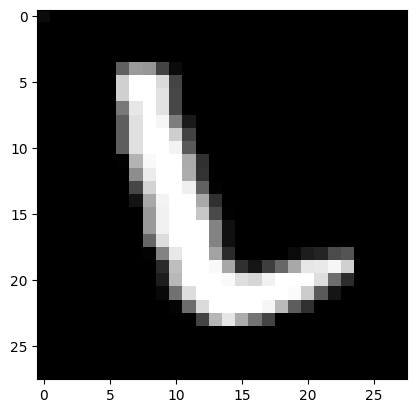

In [ ]:
image_2d = data[100000][0:784].reshape(28, 28)
plt.imshow(image_2d, cmap = 'gray')
print(data[100000][0])

In [ ]:
print(np.unique(y_train))

[  0   4   5   7   8   9  10  12  14  19  20  22  25  27  28  30  33  34
  36  37  49  54  57  64  66  67  69  74  78  80  81  91  94  96 100 103
 105 109 118 119 122 123 126 128 129 133 138 139 140 141 143 147 153 166
 167 168 176 179 185 187 189 190 196 197 199 203 206 209 213 214 215 217
 219 220 223 225 227 228 229 230 231 233 235 236 241 242 243 244 245 246
 248 249 251 252 253 254 255]


In [ ]:
np.random.shuffle(data)
X_train = data[0:int(data.shape[0]*0.8)][1:]
y_train = data[0:int(data.shape[0]*0.8)][0]
y_train = y_train.astype(int)
X_val = data[int(data.shape[0]*0.8):][1:]
y_val = data[int(data.shape[0]*0.8):][0]
y_val = y_val.astype(int)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [ ]:
for i in range(y_val.shape[0]):

  if(y_val[i]!=0):
    y_val[i]-=1


In [ ]:
yo = PCA(number_of_components = 50)
yo.fit(X_train)
X_pca_train = yo.transform(X_train)
# yo.fit(X_val)
X_pca_val = yo.transform(X_val)


In [ ]:
print(X_pca_train.shape)

(297959, 50)


In [ ]:
# Example usage
if __name__ == "__main__":

    # Train the Gradient Boosting Classifier
    gbc = GradientBoostingClassifierFromScratch(n_estimators=50, learning_rate=0.1)
    gbc.fit(X_pca_train, y_train)



Num of Trees Trained: 1
Num of Trees Trained: 2
Num of Trees Trained: 3
Num of Trees Trained: 4
Num of Trees Trained: 5
Num of Trees Trained: 6
Num of Trees Trained: 7
Num of Trees Trained: 8
Num of Trees Trained: 9
Num of Trees Trained: 10
Num of Trees Trained: 11
Num of Trees Trained: 12
Num of Trees Trained: 13
Num of Trees Trained: 14
Num of Trees Trained: 15
Num of Trees Trained: 16
Num of Trees Trained: 17
Num of Trees Trained: 18
Num of Trees Trained: 19
Num of Trees Trained: 20
Num of Trees Trained: 21
Num of Trees Trained: 22
Num of Trees Trained: 23
Num of Trees Trained: 24
Num of Trees Trained: 25
Num of Trees Trained: 26
Num of Trees Trained: 27
Num of Trees Trained: 28
Num of Trees Trained: 29
Num of Trees Trained: 30
Num of Trees Trained: 31
Num of Trees Trained: 32
Num of Trees Trained: 33
Num of Trees Trained: 34
Num of Trees Trained: 35
Num of Trees Trained: 36
Num of Trees Trained: 37
Num of Trees Trained: 38
Num of Trees Trained: 39
Num of Trees Trained: 40
Num of Tr

In [ ]:
np.unique(gbc.init_pred)

array([0.])

In [ ]:
print(y_train)

[14  9 12 ...  1 16 12]


In [ ]:
# Evaluate
y_pred = gbc.predict(X_pca_val)
# y_test_labels = np. argmax(y_val, axis=1)

accuracy = np.mean(y_pred == y_val)
print(f"Val Accuracy: {accuracy:.2f}")
y_pred = gbc.predict(X_pca_train)
# y_test_labels = np. argmax(y_val, axis=1)
accuracy = np.mean(y_pred == y_train)
print(f"train Accuracy: {accuracy:.2f}")


Predicting classes...
Predicting probabilities...
Val Accuracy: 0.49
Predicting classes...
Predicting probabilities...
train Accuracy: 0.77


In [ ]:
## Bad implementation

class GradientBoostingClassifier1:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.n_classes = None

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def to_one_hot(self, y):
        n_samples = len(y)
        one_hot = np.zeros((n_samples, self.n_classes))
        one_hot[np.arange(n_samples), y] = 1
        return one_hot

    def negative_gradient(self, y_true, y_pred):
        return y_true - y_pred

    def fit(self, X, y):
        print(f"Starting training with {self.n_estimators} estimators...")
        self.n_classes = len(np.unique(y))
        y_one_hot = self.to_one_hot(y)
        F = np.zeros((X.shape[0], self.n_classes))

        for m in range(self.n_estimators):
            print(f"Training estimator {m+1}/{self.n_estimators}...")
            p = self.softmax(F)
            residuals = self.negative_gradient(y_one_hot, p)
            trees_this_round = []

            for k in range(self.n_classes):
                print(f"Fitting regression tree for class {k}...")
                tree = DecisionTreeRegressor(max_depth=self.max_depth)
                tree.fit(X, residuals[:, k])
                F[:, k] += self.learning_rate * tree.predict(X)
                trees_this_round.append((k, tree))

            self.trees.append(trees_this_round)
        print("Training complete.")

    def predict_proba(self, X):
        print("Predicting probabilities...")
        F = np.zeros((X.shape[0], self.n_classes))
        for trees_this_round in self.trees:
            for k, tree in trees_this_round:
                F[:, k] += self.learning_rate * tree.predict(X)
        return self.softmax(F)

    def predict(self, X):
        print("Predicting classes...")
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)


In [ ]:
gbc = GradientBoostingClassifier1(n_estimators=10, learning_rate=0.1, max_depth=3)
gbc.fit(X_pca_train, y_train)


Starting training with 10 estimators...
Training estimator 1/10...
Fitting regression tree for class 0...
Fitting regression tree for class 1...
Fitting regression tree for class 2...
Fitting regression tree for class 3...
Fitting regression tree for class 4...
Fitting regression tree for class 5...
Fitting regression tree for class 6...
Fitting regression tree for class 7...
Fitting regression tree for class 8...
Fitting regression tree for class 9...
Fitting regression tree for class 10...
Fitting regression tree for class 11...
Fitting regression tree for class 12...
Fitting regression tree for class 13...
Fitting regression tree for class 14...
Fitting regression tree for class 15...
Fitting regression tree for class 16...
Fitting regression tree for class 17...
Fitting regression tree for class 18...
Fitting regression tree for class 19...
Fitting regression tree for class 20...
Fitting regression tree for class 21...
Fitting regression tree for class 22...
Fitting regression tree

In [ ]:
y_pred = gbc.predict(X_val)
accuracy = np.mean(y_pred == y_val)
print(f"Val Accuracy: {accuracy:.2f}")
y_pred = gbc.predict(X_pca_train)
accuracy = np.mean(y_pred == y_train)
print(f"Train Accuracy: {accuracy:.2f}")


Predicting classes...
Predicting probabilities...
Val Accuracy: 0.05
Predicting classes...
Predicting probabilities...
Train Accuracy: 0.77


In [ ]:
class NaiveBayesClassifier:
    def __init__(self):
        self.priors = None  # Class prior probabilities
        self.likelihoods = None  # Likelihood for each feature given class
        self.classes = None  # Unique class labels
        self.feature_stats = None  # Mean and variance for features per class

    def fit(self, X, y):
        """
        Fit the Naive Bayes model to the data.
        """
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.priors = np.zeros(n_classes)
        self.feature_stats = {cls: {'mean': [], 'var': []} for cls in self.classes}

        for idx, cls in enumerate(self.classes):
            # Get samples for the current class
            X_cls = X[y == cls]

            # Compute class prior
            self.priors[idx] = len(X_cls) / n_samples

            # Compute mean and variance for each feature
            self.feature_stats[cls]['mean'] = X_cls.mean(axis=0)
            self.feature_stats[cls]['var'] = X_cls.var(axis=0)

    def _calculate_likelihood(self, x, cls):
        """
        Calculate the likelihood of the data given the class using Gaussian distribution.
        """
        mean = self.feature_stats[cls]['mean']
        var = self.feature_stats[cls]['var']
        # Gaussian PDF
        likelihood = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((x - mean) ** 2 / var))
        return np.log(likelihood + 1e-9)  # Avoid log(0) by adding a small constant

    def _calculate_posterior(self, x):
        """
        Calculate the posterior probability for each class given the data point.
        """
        posteriors = []

        for idx, cls in enumerate(self.classes):
            # Start with the log of the prior
            prior = np.log(self.priors[idx])

            # Add the log likelihood
            likelihood = self._calculate_likelihood(x, cls).sum()
            posterior = prior + likelihood
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]  # Return class with highest posterior

    def predict(self, X):
        """
        Predict the class labels for the input data.
        """
        return np.array([self._calculate_posterior(x) for x in X])

In [ ]:
nb = NaiveBayesClassifier()
nb.fit(X_pca_train, y_train)



In [ ]:
# Predict and evaluate
y_pred = nb.predict(X_pca_val)
accuracy = np.mean(y_pred == y_val)
print(f"Val Accuracy: {accuracy:.2f}")
y_pred = nb.predict(X_pca_train)
accuracy = np.mean(y_pred == y_train)
print(f"Train Accuracy: {accuracy:.2f}")

Val Accuracy: 0.06
Train Accuracy: 0.91


In [ ]:
print(y_pred)

[ 5 12  6 14  4  7  4  3  4 16 25  3 15 14  4  3 13 12 14 14 13 14 13 12
  7 14  0  7 14 13  3 12 13 12 15 12 13 12 14 14  7 12  4 10  3 14  5  9
 21  0 14 12 12 17  5 14  4 12  7  4 14  0  6 14  0  4 14  7 17 13  6 12
  4 13  7 14 14 12 14 12  0 14 21 14 14  4 13  7  4 12 12 14 17  4  0  0
 14  0 14 14 17 10 16 14  0 13 14  4 12  3 14  5 15 14  4 12 17  7  7  0
  5  7 12  3 10 14  1 12  7  7  4 14 14 15  4  1  4  4 14 14 14  5 12 15
  5 14  4  4 14 21  9 14  4 21  6  5 14 15 12 14 14  4 14  4  4 21  4 12
  0  4  0 12 14  4  5 12 14 12 21  6 12 21  4 15 21 12 13  4  9 14 14 12
 12 12 21 16  8  4 14 14 14 14  4 11  0  6 14 16 13 10 16 14 12 17 12  4
 12 10 12  1 12  0 15  0 12  2  0  3  5 12 14 15  4  4  4 12 13 12 14  0
 12 14 14 21 10 17 14 12 10 10 13  0 14 12  5  4 14  9 14 17  7 12 10 12
  3 12  4  8 12 14 14]


In [ ]:
print(y_val)

[10 14  8 17 18  2 23  0 23 11 10  8  4 13 24 11  3  8 21 15 13  1 17 14
 10  0  6  5 14  8 21 12  8 22 18 14  3  0  4 16 20  0 23 15 16 25  5  5
 14 13 21 24 12  6  5  1  4  0  5  3  3 16  6  6  7 14  4  2 16  8 14 16
 15  6 15  6  1 25  7 12  7 17 13 15  4 15  3 21 24  4 12 12  4  7  7  3
  1  7 11  5  2 15  4  1 24 13  1 10  0  8 21  9  1  7  3  4 19 10  0 12
  7  0 13 13 15  9 10 21 10 10 15  6  6 10  3  4  6  8 11  7 16  9  3 20
  5 16  8  7 12  0  4 14 11 12 17  9 15 18 12 20 15 14 13  9 17  4 14  6
 16 25 14 24  6 17  7  7 12 20 14  0 21  2 16 20  0 25  3  4  5 21 11 14
 11 20  1 15  8  9 12 16  1  4 14 13 14 18  9 21  3 15  2  9 21  4 20 23
 12 15 16 14 13 14  7 14 22 17 17  0  5 21 14 10  5 17 11 20  6 19 12 17
 22 11 14 11  7 19 16  1 17  7 13  0 19 22  5 15  9  5 14 19 10 17  8  4
  8 25 23  8 22  6 24]
